Setting up environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Importing necessary libraries
import tensorflow as tf # tensorflow 2.x
from tensorflow.keras import models, layers
from tensorflow.keras import backend as K
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Activation, Dropout, Lambda, Conv2DTranspose, AveragePooling2D, GaussianNoise
from keras.models import Model
from keras import backend as K
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.utils.class_weight import compute_class_weight
from matplotlib import pyplot as plt
import matplotlib
import time
import numpy as np
from scipy import stats
from keras import metrics
import random
import math
import pandas as pd
import statistics
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.regularizers import l2, l1

!pip install hic-straw
import hicstraw

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Loading testing files

!wget https://www.dropbox.com/sh/3eh3lbzedwc0hrg/AABHmvN7KxvYvaQgbNwKceFha/HIC1024_deep.hic

files = ['HIC1024_deep.hic']

--2024-08-19 20:03:20--  https://www.dropbox.com/sh/3eh3lbzedwc0hrg/AABHmvN7KxvYvaQgbNwKceFha/HIC1024_deep.hic
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/raw/3eh3lbzedwc0hrg/AABHmvN7KxvYvaQgbNwKceFha/HIC1024_deep.hic [following]
--2024-08-19 20:03:21--  https://www.dropbox.com/sh/raw/3eh3lbzedwc0hrg/AABHmvN7KxvYvaQgbNwKceFha/HIC1024_deep.hic
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce21d0919f69f5589b871272431.dl.dropboxusercontent.com/cd/0/inline/CY8zYkx4CE6jwdXLEbQ9gsy9qeAqm6xSTyMv_GXGKsXaQpDQNcPC1dxyZozaa0c4WFTWE9YYGMyldWYKEmg9tQRVyXGVNj6gvYzP_glGhtNogBsilkfaI4V2vXcXNo56CydcpFBMcMe4vYxFF2_s_G0m/file# [following]
--2024-08-19 20:03:21--  https://uce21d0919f69f5589b871272431.dl.dropboxusercontent.com/cd/0/inline/CY8zYkx4C

In [ ]:
# Setting up global variables
WIDTH=10 # Size of input matrix
res=1000000 # resolution
br = matplotlib.colors.LinearSegmentedColormap.from_list("bright_red",[(1,1,1),(1,0,0)]) # color scheme
np.set_printoptions(suppress = True)
model = tf.keras.models.load_model('BinaryClassifier.h5')

Preprocessing and helper functions

In [ ]:
# OE functions

# Averages out each diagonal
# For symmetric matrices, return an array with the values on each diagonal replaced by the average of that diagonal
def replace_diagonal_with_average(arr):
  max_offset = arr.shape[0]
  for i in range(1, max_offset):
    np.fill_diagonal(arr[:i, max_offset-i:], np.mean(np.diagonal(arr, offset=max_offset-i)))
    np.fill_diagonal(arr[max_offset-i:, :i], np.mean(np.diagonal(arr, offset=i-max_offset)))
  np.fill_diagonal(arr, np.mean(np.diagonal(arr)))

  return arr

# Return a WIDTH * WIDTH array of a near-diagonal expected matrix

def get_expected_matrix(hic, res, WIDTH, sample_size = 20, data_type = 'observed', normalization = 'NONE', unit = 'BP'):
  expected_matrix = np.zeros([WIDTH, WIDTH])
  expected_matrices = np.zeros([sample_size, WIDTH, WIDTH])
  chroms = hic.getChromosomes()
  num_chroms = len(chroms)-1
  for i in range(sample_size): # Sample of matrices taken
    scaffold = int(random.random()*num_chroms)+1 # Choosing random chromosome
    chr1_start = int(random.random()*(chroms[scaffold].length//res-(WIDTH-1))) * res # Choosing random start point
    matrix = hic.getMatrixZoomData(chroms[scaffold].name, chroms[scaffold].name, data_type, normalization, unit, res)
    matrix = matrix.getRecordsAsMatrix(chr1_start, chr1_start+(WIDTH-1)*res, chr1_start, chr1_start+(WIDTH-1)*res)
    expected_matrices[i, :, :] = replace_diagonal_with_average(matrix) # Creating expected matrix


  for i in range(WIDTH):
    for j in range(WIDTH):
      expected_matrix[i, j] = np.median(expected_matrices[:, i, j]) # Taking median of expected matrices to prevent skew from abnormal examples

  return expected_matrix

In [ ]:
# Centile Rescaling

# Capping the matrix at a certain threshold and then linearly scaling between 0 and 1

def globalPercentileProcess(matrix, threshold):
  return np.where(matrix<threshold, matrix, threshold)/threshold

# Determine numerical value for centile
# Done very similarly to get_expected_matrix function above

def get_med_threshold(hic, centiles, res, WIDTH, sample_size = 20, data_type = 'observed', normalization = 'NONE', unit = 'BP'):
  thresholds=np.zeros([len(centiles), sample_size])
  chroms = hic.getChromosomes()
  num_chroms = len(chroms)-1

  for i in range(sample_size):
    chrom = int(random.random()*num_chroms)+1
    chr1_start = int(random.random()*(chroms[chrom].length//res-(WIDTH-1)))
    matrix = hic.getMatrixZoomData(chroms[chrom].name, chroms[chrom].name, data_type, normalization, unit, res)
    matrix = matrix.getRecordsAsMatrix(chr1_start, chr1_start+(WIDTH-1)*res, chr1_start, chr1_start+(WIDTH-1)*res)

    for idx, centile in enumerate(centiles):
      thresholds[idx, i] = np.percentile(matrix, centile) # Centile threshold calculated for each matrix

  final_thresholds = list()
  for i in range(len(centiles)):
    final_thresholds.append(statistics.median(thresholds[i]))

  return final_thresholds

In [ ]:
# Helper functions used in data creation
# size = WIDTH
# partp is the partition point where the first region ends and the second region begins
# partp = len(region1) = size - len(region2)

# Stitching a matrix together given the first region, second region, and common region

def construct_matrix(size, partp, matrix_chr1, matrix_chr2, matrix_comb):
  matrix = np.zeros([size, size])

  matrix[0:partp, 0:partp] = matrix_chr1
  matrix[partp:size, partp:size] = matrix_chr2

  common = matrix_comb

  matrix[0:partp, partp:size] = common
  matrix[partp:size, 0:partp] = np.flipud(np.rot90(common))

  return matrix

# Downsamples a matrix the same way Juicebox does
def hic_downsample(size, ds_scale, matrix):

  smatrix = np.zeros([int(size/ds_scale), int(size/ds_scale)])

  for i in range(int(size/ds_scale)):
    for j in range(int(size/ds_scale)):
      if i==j:
        smatrix[i, j] = np.sum(np.triu(matrix[ds_scale*i:ds_scale*(i+1), ds_scale*j:ds_scale*(j+1)]))
      else:
        smatrix[i, j] = np.sum(matrix[ds_scale*i:ds_scale*(i+1), ds_scale*j:ds_scale*(j+1)])

  return smatrix

# Determines the expected matrix and downsamples it
# observed/oe = observed / (observed/expected) = expected
def hic_expected_downsample(size, ds_scale, matrix_observed, matrix_oe):
  matrix = matrix_observed/matrix_oe
  return hic_downsample(size, ds_scale, matrix)

# Grabbing the first, second, and common chromosome regions given the start point of each region and the partition point (which gives the length of each region)
# chrom1 and chrom2 are indexes, not chromosome names
def grabFromStraw(hic, res, chrom1, chrom2, chr1_start, chr2_start, partp, size, data_type = 'observed', normalization = 'NONE', unit = 'BP'):
  chroms = hic.getChromosomes()

  matrix_chr1 = hic.getMatrixZoomData(chroms[chrom1].name, chroms[chrom1].name, data_type, normalization, unit, res)
  matrix_chr1 = matrix_chr1.getRecordsAsMatrix(chr1_start, chr1_start+(partp-1)*res, chr1_start, chr1_start+(partp-1)*res)

  matrix_chr2 = hic.getMatrixZoomData(chroms[chrom2].name, chroms[chrom2].name, data_type, normalization, unit, res)
  matrix_chr2 = matrix_chr2.getRecordsAsMatrix(chr2_start, chr2_start+(size-1-partp)*res, chr2_start, chr2_start+(size-1-partp)*res)

  matrix_comb = hic.getMatrixZoomData(chroms[chrom1].name, chroms[chrom2].name, data_type, normalization, unit, res)
  matrix_comb = matrix_comb.getRecordsAsMatrix(chr1_start, chr1_start+(partp-1)*res, chr2_start, chr2_start+(size-1-partp)*res)

  return matrix_chr1, matrix_chr2, matrix_comb

Creating examples with interchromosomal and intrachromosomal breaks

In [ ]:
# Creates interchromsomal breaks
def data_interchromosomal(hic, size=100, res = 100000, ds_scale=10):

  size *= ds_scale # Creating larger matrix to downsample later

  # If res is not a multiple of ds_scale downsampling won't work properly
  if not res%ds_scale == 0:
    print("ds_scale should be a divsor of res")
    return

  res //= ds_scale # Creating at lower resolution to downsample later

  chroms = hic.getChromosomes()
  partp = size//2 - int(random.random()*ds_scale) # Partition point should be in the last bin of the first half of the downsampled matrix (e.g. 5th bin in 10 by 10 matrix)
  chrom1 = int(random.random()*(len(chroms)-1))+1 # Selecting a chromosome by getting its index in chroms
  # Selecting 0 as an index is invalid because chroms[0] is All

  # Selecting a second, different chromosome
  chrom2 = chrom1
  while(chrom2==chrom1):
    chrom2 = int(random.random()*(len(chroms)-1))+1

  # Checking if both chromosomes are larger than the regions that will be drawn from them
  if (chroms[chrom1].length<res*partp or chroms[chrom2].length<(size-partp)*res):
    # Rerunning the function if the answer is no
    return data_interchromosomal(hic, size//ds_scale, res*ds_scale, ds_scale)

  # Getting a random start location (at a multiple of res) so the full region will fit in between the start location and end of the chromosome
  chr1_start = int(random.random()*(chroms[chrom1].length//res-partp+1))*res
  chr2_start = int(random.random()*(chroms[chrom2].length//res-size+1+partp))*res

  # Grabbing and constructing observed matrix
  matrix_chr1, matrix_chr2, matrix_comb = grabFromStraw(hic, res, chrom1, chrom2, chr1_start, chr2_start, partp, size, 'observed', 'NONE', 'BP')
  matrix = construct_matrix(size, partp, matrix_chr1, matrix_chr2, matrix_comb)

  # Grabbing and constructing oe matrix
  matrix_chr1, matrix_chr2, matrix_comb = grabFromStraw(hic, res, chrom1, chrom2, chr1_start, chr2_start, partp, size, 'oe', 'NONE', 'BP')
  matrix2 = construct_matrix(size, partp, matrix_chr1, matrix_chr2, matrix_comb)

  # Downsampling
  observed_matrix = hic_downsample(size, ds_scale, matrix)
  expected_matrix = hic_expected_downsample(size, ds_scale, matrix, matrix2)

  # np.inf is the distance between two regions on different chromosomes
  return observed_matrix, observed_matrix/expected_matrix, np.inf

In [ ]:
# Creates an intrachromosomal break with two regions a specified distance apart
def data_specific_distance_intrachromosomal(hic, size=100, res = 100000, ds_scale=10, distance=0):

  size *= ds_scale
  if not res%ds_scale == 0:
    print("ds_scale should be a divsor of res")
    return
  res //= ds_scale

  chroms = hic.getChromosomes()
  partp = size//2 - int(random.random()*ds_scale)
  chrom = int(random.random()*(len(chroms)-1))+1

  # Checks to see if chromosome is large enough to create example
  if chroms[chrom].length<res*partp+distance:
    return data_specific_distance_intrachromosomal(hic, size//ds_scale, res*ds_scale, ds_scale, distance)

  chr_start = int(random.random()*(chroms[chrom].length//res-size-distance//res)) * res
  chr_continue = chr_start + distance + partp*res

  matrix_chr1, matrix_chr2, matrix_comb = grabFromStraw(hic, res, chrom, chrom, chr_start, chr_continue, partp, size, 'observed', 'NONE', 'BP')
  matrix = construct_matrix(size, partp, matrix_chr1, matrix_chr2, matrix_comb)

  matrix_chr1, matrix_chr2, matrix_comb = grabFromStraw(hic, res, chrom, chrom, chr_start, chr_continue, partp, size, 'oe', 'NONE', 'BP')
  matrix2 = construct_matrix(size, partp, matrix_chr1, matrix_chr2, matrix_comb)

  observed_matrix = hic_downsample(size, ds_scale, matrix)
  expected_matrix = hic_expected_downsample(size, ds_scale, matrix, matrix2)

  return observed_matrix, observed_matrix/expected_matrix, distance

Distance vs. Probability

In [ ]:
med_prob = np.zeros([101])
err = np.zeros([2, 101])

distances = list(range(101)) # Range of distances
predictions = np.zeros([101, 10])
c = 1000*1000 # constant value to multiply with
hic = hicstraw.HiCFile(files[0])
expected_matrix = get_expected_matrix(hic, res, WIDTH) # Manually creating expected matrix
thresholds = get_med_threshold(hic, [95, 90, 80], res, WIDTH)

for distance in distances:
  for j in range(10):
    observed, _, __ = data_specific_distance_intrachromosomal(hic = hic, size = WIDTH, res = res, ds_scale=10, distance=distance*c) # Generating example at a particular distance
    input_matrix = np.zeros([1, WIDTH, WIDTH, 3])
    input_matrix[0, :, :, 0] = globalPercentileProcess(observed, thresholds[0]) # Preprocessing
    input_matrix[0, :, :, 1] = globalPercentileProcess(observed, thresholds[1])
    input_matrix[0, :, :, 2] = globalPercentileProcess(observed, thresholds[2])
    predictions[distance, j] = model.predict(input_matrix) # Prediction

  med_prob[distance] = np.median(predictions[distance]) # Median probability
  err[0, distance] = med_prob[distance]-np.percentile(predictions[distance], 25) # Error bars from 25th to 75th percentile
  err[1, distance] = np.percentile(predictions[distance], 75)-med_prob[distance]

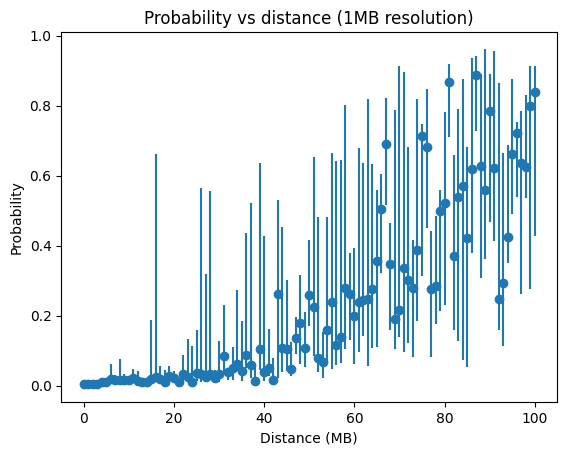

In [ ]:
# Plotting probability vs distance

plt.errorbar(distances, med_prob, yerr=err, fmt='o')
# plt.scatter(distance, med_prob)
plt.title("Probability vs Distance (" + str(res//1000000) +  "MB resolution)")
plt.xlabel("Distance (MB)")
plt.ylabel("Probability")
plt.savefig(str(res//1000000) + "MB Intrachromosomal Plot")

In [ ]:
# Generating interchromsomal examples

predictions = np.zeros([100])
hic = hicstraw.HiCFile(files[0])
expected_matrix = get_expected_matrix(hic, res, WIDTH)
thresholds = get_med_threshold(hic, [95, 90, 80], res, WIDTH)

for j in range(100):
  observed, _, __ = data_interchromosomal(hic = hic, size = WIDTH, res = res, ds_scale=10)
  input_matrix = np.zeros([1, WIDTH, WIDTH, 3])
  input_matrix[0, :, :, 0] = globalPercentileProcess(observed, thresholds[0])
  input_matrix[0, :, :, 1] = globalPercentileProcess(observed, thresholds[1])
  input_matrix[0, :, :, 2] = globalPercentileProcess(observed, thresholds[2])
  predictions[j] = model.predict(input_matrix)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


<ipython-input-15-0e2f25d3d5d5>:38: RuntimeWarning: invalid value encountered in divide
  matrix = matrix_observed/matrix_oe
<ipython-input-33-b74d8284ce47>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predictions[j] = model.predict(input_matrix)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

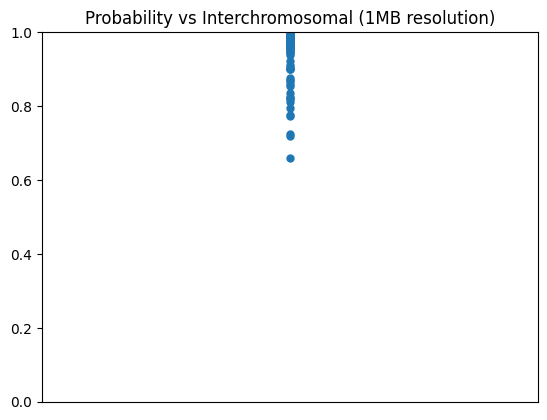

In [ ]:
fig, ax = plt.subplots()
# Plot the data
ax.plot(np.zeros_like(predictions), predictions, 'o', markersize=5)
# Set the title and y-axis limits
ax.set_title("Probability vs Interchromosomal (" + str(res // 1000000) + "MB resolution)")
ax.set_ylim(0, 1)  # Ensure y-axis is from 0 to 1
# Hide the x-axis
ax.get_xaxis().set_visible(False)
# Save the figure
plt.savefig(str(res // 1000000) + "MB Interchromosomal Plot")